In [93]:
#importing libraries and dataset
import pandas as pd
import requests
import io

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv")

df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [63]:
#changing Month to datetime
datetime = pd.to_datetime(df['Month'])
datetime

0     1964-01-01
1     1964-02-01
2     1964-03-01
3     1964-04-01
4     1964-05-01
         ...    
100   1972-05-01
101   1972-06-01
102   1972-07-01
103   1972-08-01
104   1972-09-01
Name: Month, Length: 105, dtype: datetime64[ns]

In [64]:
df.index = datetime

In [68]:
df.drop(columns="Month", inplace=True)

In [69]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [22]:
#creating a timeseries using sales and dates
ts = pd.Series(df['Sales'].values, index=datetime)

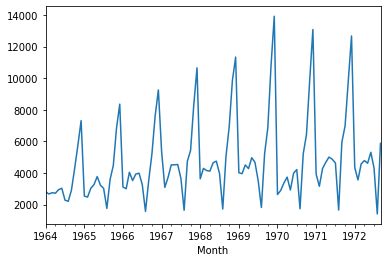

In [24]:
import matplotlib.pyplot as plt
#a quick look for patterns:
ts.plot()
plt.show()

It's clear that there is major seasonality and irregularity.

**The weighted rolling mean**

A drawback of the rolling mean approach is that the window has to be strictly defined. In this case, we can take yearly averages but in complex situations like forecasting a stock price, it may be difficult to come up with an exact number. So we take a "weighted rolling mean" (or weighted moving average, WMA for short) where more recent values are given a higher weight. There are several techniques for assigning weights.

A popular one is Exponentially Weighted Moving Average where weights are assigned to all the previous values with an exponential decay factor. This can be implemented in Pandas with .ewm() method.

In [32]:
#function to evaluate stationarity
def stationarity_check(df):
    from statsmodels.tsa.stattools import adfuller
    import matplotlib.pyplot as plt
    %matplotlib inline
  
    
    #calculate the rolling mean and std
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    #visualizing
    fig = plt.figure(figsize = (12,8));
    plt.plot(df, color='b', label='Original')
    plt.plot(roll_mean, color='r', label='Rolling Mean')
    plt.plot(roll_std, color='g', label='Standard Deviation')
    plt.title('Rolling Mean and STD')
    plt.legend()
    plt.show()
   
    
    #Testing
    dftest = adfuller(df)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ('Results of Dickey-Fuller test: \n')
    print(dfoutput)

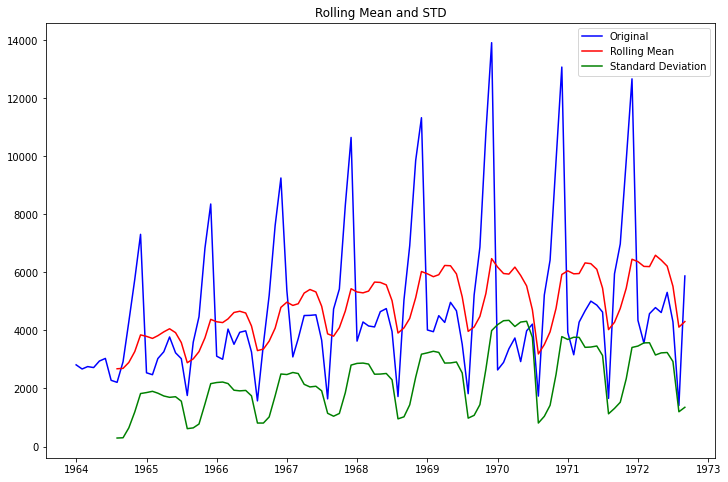

Results of Dickey-Fuller test: 

Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [33]:
stationarity_check(ts)

tests the null hypothesis that a **unit root** is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [48]:
ts.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='Month', length=105, freq=None)

## EDA and Decomposition:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BCFDB00B8>]],
      dtype=object)

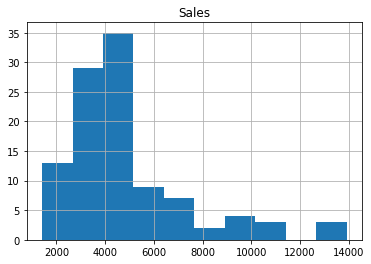

In [70]:
df.hist() 

non-normal distribution... can it be normalized with log-transformation?

(array([ 7.,  2.,  7., 18., 25., 24.,  8.,  4.,  6.,  4.]),
 array([7.25347038, 7.4822028 , 7.71093521, 7.93966763, 8.16840004,
        8.39713246, 8.62586487, 8.85459729, 9.08332971, 9.31206212,
        9.54079454]),
 <a list of 10 Patch objects>)

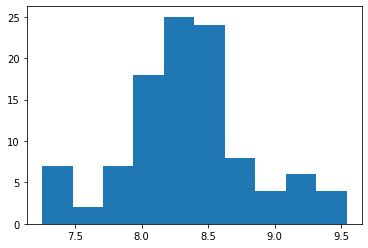

In [71]:
x= df.values
X = np.log(x)
plt.hist(X)


yup

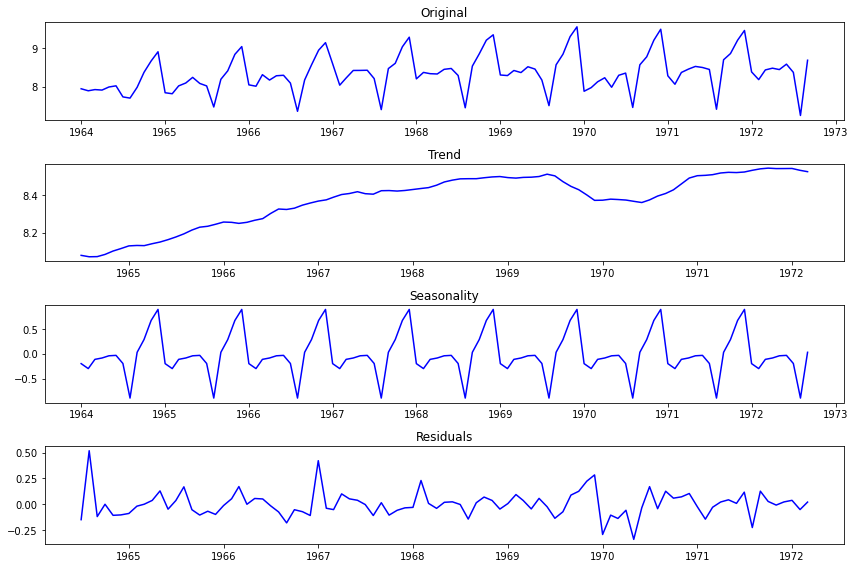

In [72]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

feats = (np.log(df), trend, seasonal, residual)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,8))

ax[0].plot(np.log(df), color='blue')
ax[0].set_title('Original')
ax[1].plot(trend, color='blue')
ax[1].set_title('Trend')
ax[2].plot(seasonal, color='blue')
ax[2].set_title('Seasonality')
ax[3].plot(residual, color='blue')
ax[3].set_title('Residuals')

plt.tight_layout()

In [74]:
len(df.values)

105

In [78]:
split = round(len(X) / 2 -.5) #105 is odd
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8.243418, mean2=8.453150
variance1=0.173122, variance2=0.262389


In [79]:
df_copy = df.copy()

In [80]:
df_copy['Sales_log'] = np.log(df['Sales'])

In [81]:
df_copy.drop('Sales', axis=1, inplace=True)

In [89]:
#converting df to Series
df_log = df_copy.squeeze()

In [92]:
df_log.isna().sum()

0

In [91]:
type(df_log)

pandas.core.series.Series

In [90]:
from statsmodels.tsa.stattools import adfuller as af

result = af(df_log, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.255119
p-value: 0.186852
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584
